# Functions and Function Spaces

Operator learning is motivated by the fact that many problems in science and
engineering are formulated in terms of functions.
While conventional neural networks learn between vector-spaces, neural operators
learn mappings between infinite-dimensional function spaces.

This notebook gives an introduction into functions, function spaces (or function sets),
and how these concepts are implemented in continuiti.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Functions

A function is a mapping between a set $X$ (domain) and a set $Y$ (co-domain),
denoted by

\begin{align*}
f: X &\rightarrow Y, \\
x &\mapsto f(x).
\end{align*}


For example, the function $f(x)=x^2$ maps each element $x\in X = [-1,1] \subset \mathbb{R}$ to an element of $Y = [0,1] \subset \mathbb{R}$.

In continuiti, functions are handled by a `Function` object that takes a callable as input.
As an example, we define two functions $f$ and $g$: 

$$
f(x) = \sin(\pi x), \qquad g(x) = x^3, \qquad x\in \mathbb{R}.
$$

In [3]:
from continuiti.data.function import Function

f = Function(lambda x: torch.sin(torch.pi * x))
g = Function(lambda x: x ** 3)

Functions are evaluated by calling them.

In [4]:
x = torch.linspace(-1, 1, 100)
y = f(x)
z = g(x)

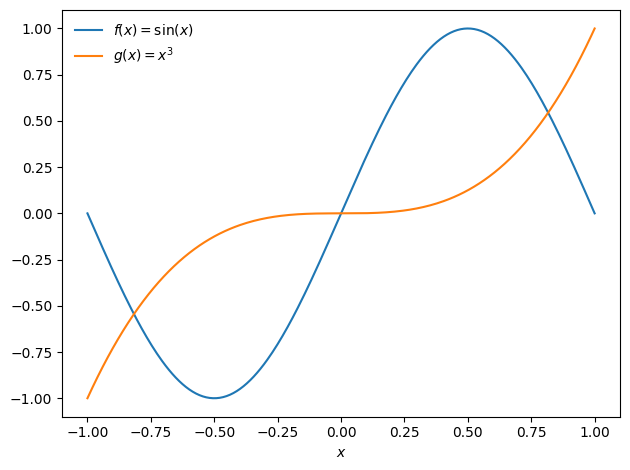

In [5]:
x_plot = torch.linspace(-1, 1, 300)
plt.plot(x_plot, f(x_plot), label="$f(x)=\sin(x)$")
plt.plot(x_plot, g(x_plot), label="$g(x)=x^3$")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()

Functions can be added to other function instances and multiplied by scalars.
For instance:

In [6]:
h_1 = f + g
h_2 = (-1) * (f + g)

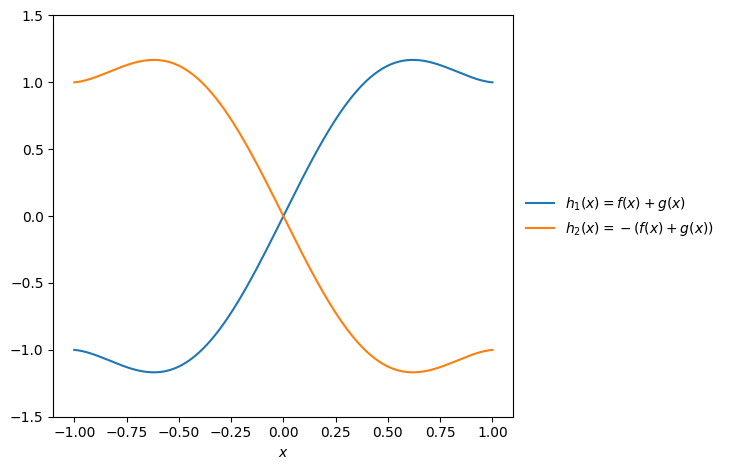

In [7]:
fig, ax = plt.subplots()
ax.plot(x_plot, h_1(x_plot), label="$h_1(x)=f(x)+g(x)$")
ax.plot(x_plot, h_2(x_plot), label="$h_2(x)=-(f(x)+ g(x))$")
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("$x$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Function Sets

 Let $X$ be a domain supported on a field $K_1$, and let $Y$ be the codomain supported on a field $K_2$. A function space is the set of functions $F(X, Y)$ that map from $X$ to $Y$ and are closed with respect to addition
 $$
 (f+g)(x):X \rightarrow Y, x\mapsto f(x)+g(x),
 $$
 and scalar multiplication
 $$
 (c\cdot f)(x) \rightarrow Y, x\mapsto c\cdot f(x).
 $$

In practice, we consider subsets of function spaces (where in general, these properties are not respected) and,
    therefore, this class implements a (parametrized) function set.
Here, we define the following set of sine waves
$$
y = \beta \sin(k\pi x),\quad A=[\beta, k]^\top\in\mathbb{R}^2,\quad x, y\in\mathbb{R}.
$$
In continuiti, function sets are handled by a `FunctionSet` that takes a nested callable as input.
When `FunctionSet` is called with a set of parameters it returns a list of `Function` instances.

In [8]:
from continuiti.data.function import FunctionSet

sine_set = FunctionSet(lambda a: Function(lambda x: a[0] * torch.sin(a[1] * torch.pi * x)))

parameters = 5 * torch.rand(2, 4)  # 2 parameters in 4 sets

sines = sine_set(parameters)

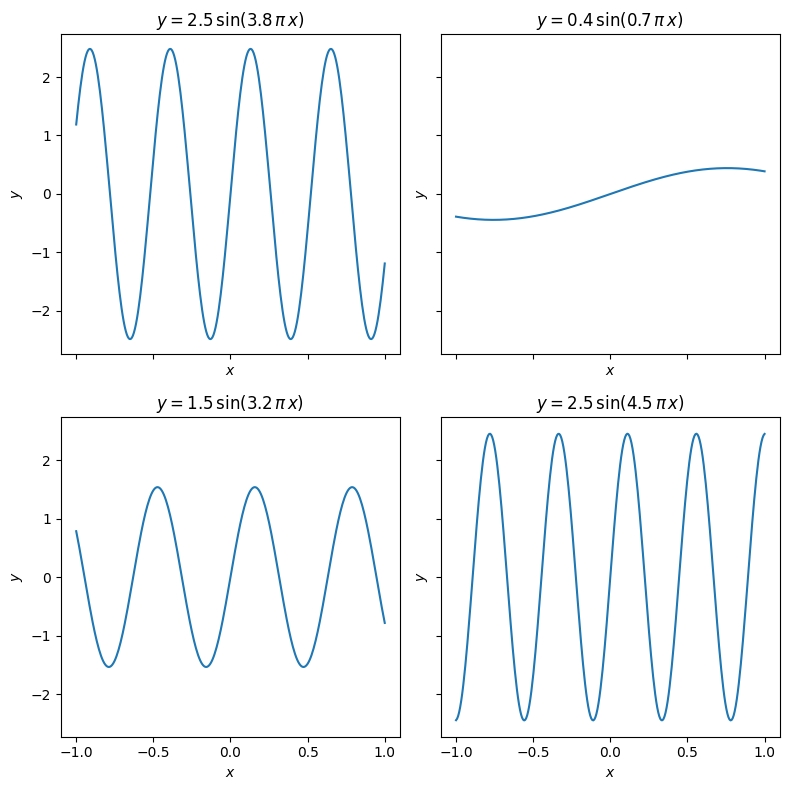

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

for i, sine in enumerate(sines):
    pi = parameters[:, i]
    row, col = i // 2, i % 2
    param = [f'{nbr: .1f}' for nbr in pi.tolist()]
    axs[row, col].plot(x_plot, sine(x_plot))
    axs[row, col].title.set_text(rf"$y={param[0]}\,\sin({param[1]}\,\pi\,x)$")
    axs[row, col].set_xlabel("$x$")
    axs[row, col].set_ylabel("$y$")
fig.tight_layout()

## Sampler

In continuiti, there are samplers to create discrete representations of continuous functions. The following example shows how the `RegularGridSampler` and the `UniformBoxSampler` handle this. Both take two corner points of a $n$-dimensional rectangle as inputs. 

In [10]:
from continuiti.discrete import RegularGridSampler, UniformBoxSampler

sampler_a = RegularGridSampler([1., 1.], [1.5, 2.5])
sampler_b = UniformBoxSampler([1.75, 1.25], [3., 1.75])

n_samples = 102
samples_a = sampler_a(n_samples)
samples_b = sampler_b(n_samples)

print(f"Shape of sample A: {samples_a.shape} (as 6 x 17 = 102), Shape of sample B: {samples_b.shape}")

Shape of sample A: torch.Size([2, 6, 17]) (as 6 x 17 = 102), Shape of sample B: torch.Size([2, 102])


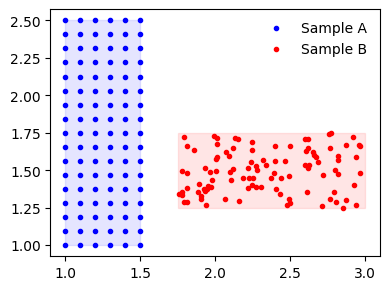

In [11]:
fig, ax = plt.subplots(figsize=(4, 8))
ax.plot(samples_a[0].flatten(), samples_a[1].flatten(), 'b.', label="Sample A")
a_bbox = patches.Rectangle((1, 1), .5, 1.5, alpha=0.1, color='b')
ax.add_patch(a_bbox)
ax.plot(samples_b[0], samples_b[1], 'r.', label="Sample B")
b_bbox = patches.Rectangle((1.75, 1.25), 1.25, .5, alpha=0.1, color='r')
ax.add_patch(b_bbox)
ax.set_aspect(1)
ax.legend()
fig.tight_layout()

Now, we can use these samplers to draw samples from our previously defined sine wave $y = \beta \sin(k\pi x)$. In a first step, we will draw from the parameter space. In a second step, we draw from the domain.

In [12]:
parameter_sampler = RegularGridSampler([1., 1.], [2., 2.])
domain_sampler = UniformBoxSampler([-1.], [1.])

# sample parameter space
n_parameter_samples = 9
parameter_samples = parameter_sampler(n_parameter_samples).reshape(2, -1)
sines = sine_set(parameter_samples)

# sample domain
n_sensors = 32
x = []
y = []
for sine in sines:
    xi = domain_sampler(n_sensors)
    x.append(xi)
    yi = sine(xi)
    y.append(yi)
x = torch.stack(x)
y = torch.stack(y)

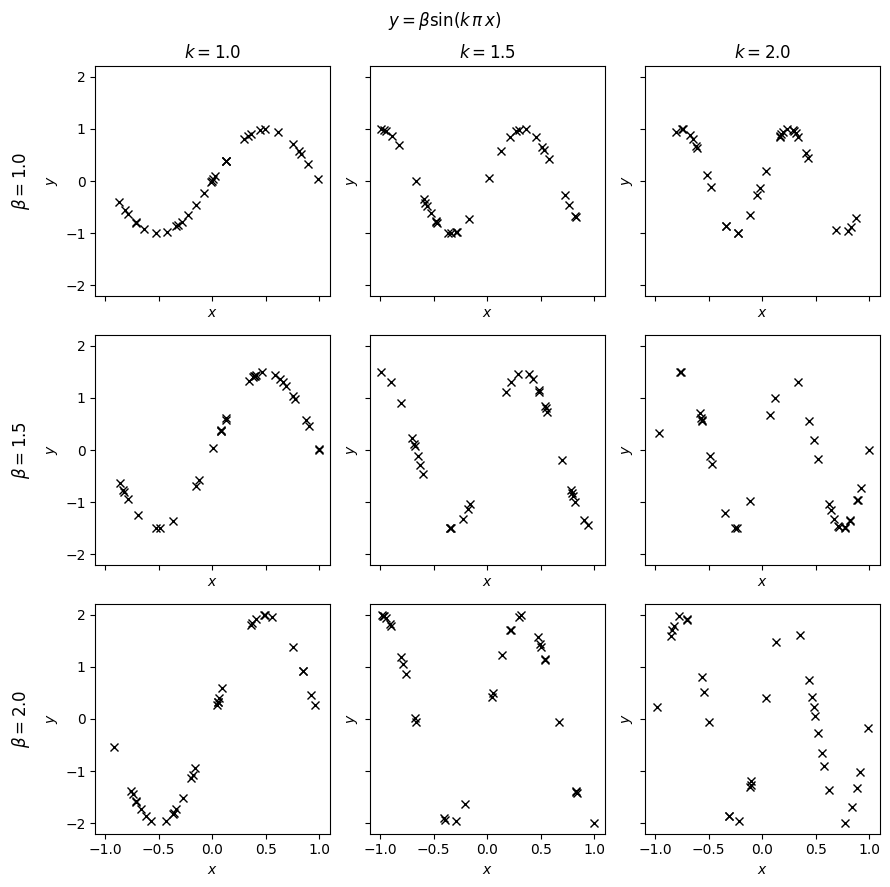

In [13]:
fig, axs = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(9, 9))

for i, (xi, yi) in enumerate(zip(x, y)):
    param = parameter_samples[:, i]
    row, col = i // 3, i % 3
    idx = torch.argsort(xi.squeeze())
    axs[row, col].plot(xi[:, idx], yi[:, idx], 'kx')
    axs[row, col].set_ylabel("$y$")
    axs[row, col].set_xlabel("$x$")

cols = [f"$k={k:.1f}$" for k in torch.linspace(parameter_sampler.x_min[1], parameter_sampler.x_max[1], 3)]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
rows = [rf"$\beta={b:.1f}$" for b in torch.linspace(parameter_sampler.x_min[0], parameter_sampler.x_max[0], 3)]
for ax, row in zip(axs[:, 0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
fig.suptitle(r"$y=\beta \sin(k\,\pi\, x)$")
fig.tight_layout()

## Function Operator Datasets

In continuiti, the concepts of function sets and samplers are combined to form `FunctionOperatorDataset` instances. This class is used to handle scenarios where both the input function set $U$ and the output function set $V$ of an operator $G$ are known. It utilizes samplers to generate samples to generate a training set.

!!! note

    The `FunctionOperatorDataset` assumes that both function sets are defined on the same parameters.

In this example, we show how to generate a derivative operator dataset
$$
G:u\mapsto \partial_x u,
$$
for the parameterized sine function
$$
u_a: x\mapsto \sin(ax), \quad a, x\in \mathbb{R},
$$
and its derivative
$$
v_a: x\mapsto a\cos(ax), \quad a,x \in \mathbb{R}.
$$

In [14]:
from continuiti.data.function import FunctionOperatorDataset

u_set = FunctionSet(lambda a: Function(lambda xi: torch.sin(a * xi)))
v_set = FunctionSet(lambda a: Function(lambda xi: a * torch.cos(a * xi)))

x_sampler = RegularGridSampler([-1], [1.])
y_sampler = UniformBoxSampler([-2], [.5])
parameter_sampler = RegularGridSampler([torch.pi], [2 * torch.pi])

dset = FunctionOperatorDataset(
    input_function_set=u_set,
    x_sampler=x_sampler,
    n_sensors=64,
    output_function_set=v_set,
    y_sampler=y_sampler,
    n_evaluations=128,
    parameter_sampler=parameter_sampler,
    n_observations=4,
)

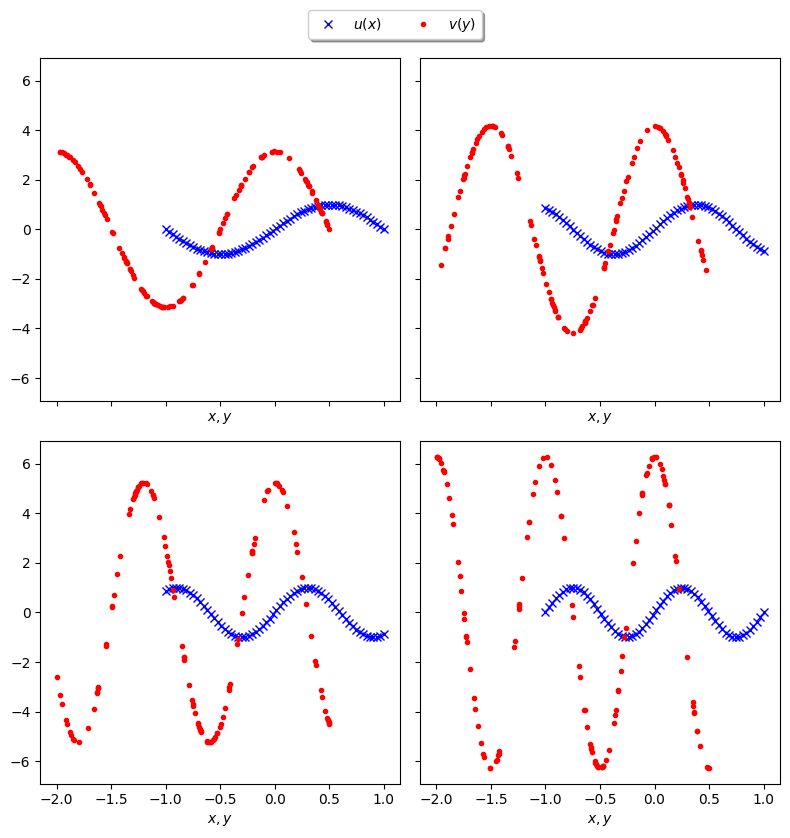

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

for i, (x, u, y, v) in enumerate(dset):
    row, col = i // 2, i % 2
    axs[row, col].plot(x, u, 'bx', label="$u(x)$")
    idx = torch.argsort(y.squeeze())
    y_plot, v_plot = y[:, idx], v[:, idx]
    axs[row, col].plot(y_plot, v_plot, 'r.', label=r"$v(y)$")
    axs[row, col].set_xlabel("$x, y$")
lines_labels = [ax.get_legend_handles_labels() for ax in axs.flatten()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
by_label = dict(zip(labels, lines))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=2, fancybox=True, shadow=True)
fig.tight_layout()